# K-nearest neighbors
Notation per Artificial Intelligence: A Modern Approach (AIMA)
Further resources: [IBM](https://www.ibm.com/topics/knn)
>K-nearest-neighbors is a clustering algorithm that is used to cluster data based on the distance between points.
>A KNN-lookup uses a function $NN(k,x_q)$ to find the $k$-nearest examples for a given query $x_q$.

Applications:
- Classification by taking a majority vote of the nearest neighbors
- Regression by averaging the values of the nearest neighbors

Pro
- Adapts easily to new examples

Con
- Bad scalability due to the need to store all the training data
- Curse of dimensionality: Number of dimensions increases --> number of neighbors required to approximate the target function increases (exponentially)
- Prone to overfitting: Curse of dimensiionality + small $k$ --> overfitting
    - Requires dimensionality reduction
    - Large $k$ can smooth out the decision boundary
- Too large $k$ can lead to underfitting

## Choosing a value for $k$
- Low values of $k$
    - High variance
    - Low bias
    - If $k=1$ (single neighbor) the algorithm is sensitive to noise and outliers.
- High values of $k$
    - Low variance
    - High bias
- Choosing a odd value for $k$ is recommended to avoid ties in the majority vote.

## Distance functions
There are many different distance functions that can be used to find the nearest neighbors. Usually the distance function is chosen based on the type of data that is being clustered.
- Minkowski distance: $d(x,y) = \sqrt[p]{\sum_{i=1}^n |x_i - y_i|^p}$
    - $p=1$ is the Manhattan distance: $d(x,y) = \sum_{i=1}^n |x_i - y_i|$. Used to measure similar properties e.g. height, weight, age, etc.
    - $p=2$ is the Euclidean distance: $d(x,y) = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}$. Used to measure dissimilar properties e.g. color, shape, etc.
- Hamming distance: $d(x,y) = \sum_{i=1}^n |x_i - y_i|$. Used to measure the distance between binary vectors by counting the number of positions in which the corresponding symbols are different.

## Preprocessing
- Typical problem: Distance functions are affected by changes in unit directioins. For example, if we have a dataset with two features, one measured in meters and the other in kilometers, the distance function will be affected by the unit of measurement. 
- Solutions:
    - Normalization: $x_i = \frac{x_i - \mu_i}{\sigma_i}$
    - Mahalanobis distance: $d(x,y) = \sqrt{(x-y)^T S^{-1} (x-y)}$ where $S$ is the covariance matrix of the data. This distance function is invariant to linear transformations of the data.

## KNN algorithm
There are different ways to implement a KNN algorithm.
- Computing the distance between the query point and all training points. Then choose the $k$ nearest neighbors.
- Using $k$-d trees (balanced binary tree with $k$-dimensions) to store the training data. 
- Using locality-sensitive hashing (LSH) to store the training data. LSH maps similar items to the same buckets with high probability.

### Locality-sensitive hashing LSH
- Maps similar items to the same buckets with high probability --> tries to produce collisions for similar items.
- Used to find similar items in a large dataset.
- Used to store training data, makes it easy to find the nearest neighbors of a query point (similar items are stored in the same bucket).
- There are different implementations of LSH, one is using a random projection [towards data science](https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23), [machinelearninginterview](https://machinelearninginterview.com/topics/machine-learning/explain-locality-sensitive-hashing-for-nearest-neighbour-search/).

##### LSH using random projection
- Construct hash table where each bin is represented by a random vector $r$ described by a bitwise hash value. Examples with simillar hash values are likely to be similar.
- The random vectors can be thought of as hyperplanes that divide the space. The bitwise hash value is determined by the side of the hyperplane on which the example lies. It therefore encodes its location relative to the hyperplane.

Algorithm:
1. Create $k$ vectors with length $d$.
    - $k$: number of hash functions, size of bitwise hash value
    - $d$: dimensionality of the data
2. For each vector $v$ in the dataset.
    - Compute dot product of random vectors $r_i$ and $v$: $h_i(v) = r_i \cdot v$
    - Set bit based on dot product result: set bit to 0: $h_i(v) = 1$ if $r_i \cdot v \geq 0$, $h_i(v) = 0$ if $r_i \cdot v < 0$
3. Concatenate bit values for $k$ calculated dot products.
4. Repeat steps 2 and 3 for all vectors / observations in the dataset.
5. Group observations with same bitwise hash value in the same bucket to create hash table.

In [299]:
import numpy as np
import matplotlib.pyplot as plt

from oli.math.math_utility import pretty_print_matrix

In [300]:
SEED = 42
np.random.seed(SEED)

In [301]:
class LSHTable:
    hash_table: dict
    projections: np.ndarray

    def __init__(self, hash_size_k: int, input_dimensions: int, print_info: bool = False):
        """
        :param hash_size_k: The number of hash functions to use. This is the size of the bitwise hash value.
        :param input_dimensions: The number of dimensions of the input vector.
        """
        self.hash_table = {}
        self.projections = np.random.randn(hash_size_k, input_dimensions)
        if print_info:
            pretty_print_matrix(self.projections, f"Random projections generated for {input_dimensions} input dimensions and {hash_size_k} hash functions.")

    def _hash(self, input_vector: np.ndarray, print_info: bool = False):
        dot_product: np.ndarray = np.dot(input_vector, self.projections.T)
        bools: np.ndarray = (dot_product > 0).astype('int')
        if print_info:
            pretty_print_matrix(input_vector, "Input vector.")
            pretty_print_matrix(self.projections, "Random projections.")
            pretty_print_matrix(dot_product, "Dot product of input vector and random projections.")
        return ''.join(bools.astype('str'))
    
    def __setitem__(self, input_vector: np.ndarray, label: str, print_info: bool = False):
        hash_value = self._hash(input_vector, print_info)
        self.hash_table[hash_value] = self.hash_table.get(hash_value, []) + [label]
        if print_info:
            print(f"Added {input_vector} with label {label} to hash table.\tHash value: {hash_value}")

    def __getitem__(self, input_vector: np.ndarray):
        hash_value = self._hash(input_vector)
        return self.hash_table.get(hash_value, [])

In [302]:
lsh_table = LSHTable(4, 2, print_info=True)

Random projections generated for 2 input dimensions and 4 hash functions.
[
  0.4967141530112327 -0.13826430117118466 
  0.6476885381006925 1.5230298564080254 
  -0.23415337472333597 -0.23413695694918055 
  1.5792128155073915 0.7674347291529088 
]


In [303]:
lsh_table.__setitem__([1, 2], "a", print_info=True)
lsh_table[[3, 4]] = "b"
lsh_table[[50, 60]] = "c"
lsh_table[[30, 40]] = "e"

Input vector.
[
  1 
  2 
]
Random projections.
[
  0.4967141530112327 -0.13826430117118466 
  0.6476885381006925 1.5230298564080254 
  -0.23415337472333597 -0.23413695694918055 
  1.5792128155073915 0.7674347291529088 
]
Dot product of input vector and random projections.
[
  0.22018555066886336 
  3.693748250916743 
  -0.7024272886216971 
  3.1140822738132092 
]
Added [1, 2] with label a to hash table.	Hash value: 1101


In [304]:
print(lsh_table.hash_table)

{'1101': ['a', 'b', 'c', 'e']}


In [305]:
query = np.array([2, 1])
query_result = lsh_table[query]
print(query_result)

['a', 'b', 'c', 'e']


In [306]:
print(lsh_table._hash(query))
print(lsh_table.hash_table)

1101
{'1101': ['a', 'b', 'c', 'e']}


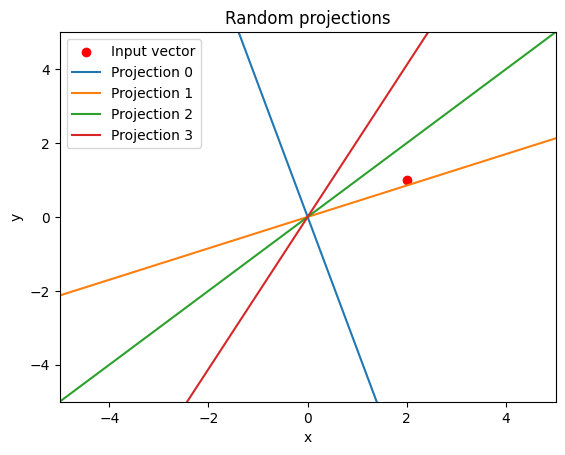

In [307]:
def plot_projections(projections: np.ndarray, input_vector: np.ndarray, ax: plt.Axes):
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Random projections")
    ax.scatter(input_vector[0], input_vector[1], color="red", label="Input vector")
    for i, projection in enumerate(projections):
        ax.plot([-5, 5], [-projection[0] * 5 / projection[1], projection[0] * 5 / projection[1]], label=f"Projection {i}")
    ax.legend()

plot_projections(lsh_table.projections, query, plt.gca())

A single LSH table is not enough to find the nearest neighbors of a query point because it only stores similar items with some probability. Therefore, we need to use multiple LSH tables to increase the probability of finding the nearest neighbors of a query point.

In [308]:
class LSH:
    lsh_tables: list

    def __init__(self, hash_size_k: int, input_dimensions: int, num_tables: int):
        self.lsh_tables = [LSHTable(hash_size_k, input_dimensions) for _ in range(num_tables)]

    def __setitem__(self, input_vector: np.ndarray, label: str):
        for lsh_table in self.lsh_tables:
            lsh_table[input_vector] = label

    def __getitem__(self, input_vector: np.ndarray):
        results = []
        for lsh_table in self.lsh_tables:
            results.extend(lsh_table[input_vector])
        return results

In [309]:
# Example
lsh = LSH(8, 2, 10)

lsh[[1, 2]] = "a"
lsh[[3, 4]] = "b"
lsh[[50, 60]] = "c"
lsh[[15, 20]] = "d"
lsh[[30, 40]] = "e"

In [310]:
query = np.array([2, 1])
print(lsh[query])

['c']
